# Testing Model

In [1]:
from core.networks import La3net
from core.datasets import LA3Duplicate

import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [3]:
dataset = LA3Duplicate(root="./data/near_duplicates", transform=preprocess)

In [4]:
dataset

Dataset LA3Duplicate
    Number of datapoints: 240
    Root location: C:\Users\Shadow\Documents\private\projects\la3net\data\near_duplicates
    Compose(
    Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)

In [5]:
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

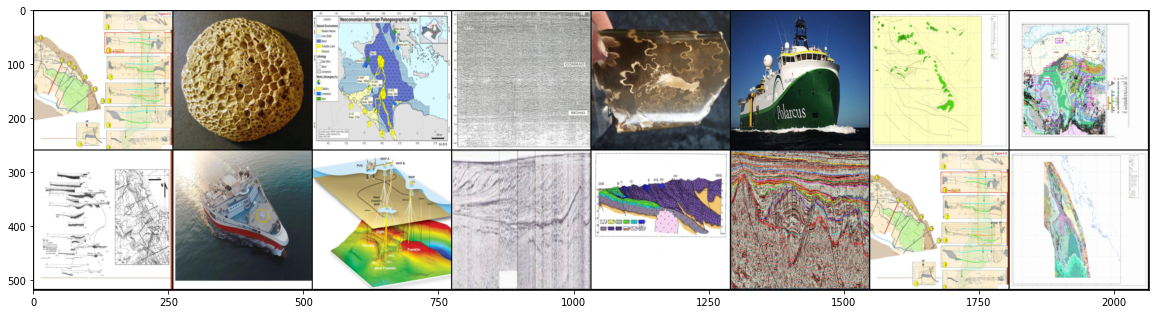

In [7]:
inputs = next(iter(dataloader))
out = torchvision.utils.make_grid(inputs[:16])
plt.rcParams["figure.figsize"] = (20, 10)
imshow(out)

In [8]:
model = La3net().to(device)
for param in model.parameters():
    param.requires_grad = False

targets = next(iter(dataloader))
target = targets[:1].to(device)
target.size()

torch.Size([1, 3, 256, 256])

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
imshow(target[0].cpu())

In [9]:
def find_similar(model, target, number=5, threshold=0.8):
    since = time.time()

    _, c, h, w = target.size()
    top_coefs = torch.zeros(number)
    top_imgs = torch.zeros((number, c, h, w))
    marker = 0

    for inputs in dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs, target)
        indices = torch.where(outputs >= threshold)[0]
        
        for indice in indices:
            print("INDICE :", indice)
            if marker<number:
                top_coefs[marker] = outputs[indice]
                top_imgs[marker, :, :, :] = inputs[indice]
                marker += 1
            else:
                break
        
        if marker>=number:
            break
    
    print(f"Search duration: {time.time() - since}s.")
    return top_imgs, top_coefs

In [10]:
top_imgs, top_coefs = find_similar(model, target)

INDICE : tensor(2, device='cuda:0')
INDICE : tensor(26, device='cuda:0')
Search duration: 34.62799429893494s.


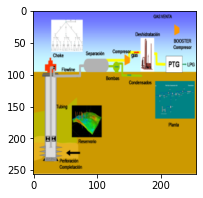

In [11]:
plt.rcParams["figure.figsize"] = (3, 3)
imshow(target[0].cpu())

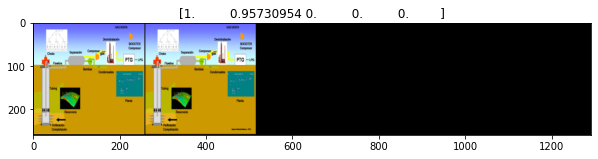

In [12]:
out = torchvision.utils.make_grid(top_imgs)
plt.rcParams["figure.figsize"] = (10, 10)
imshow(out.cpu(), title=top_coefs.numpy())